# Sequences

There are two main types of sequence problems: time series and natural language
processing (NLP).

In [ ]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from torch.nn.utils import rnn as rnn_utils


In [ ]:
import utils

# Sequences

## Data Generation

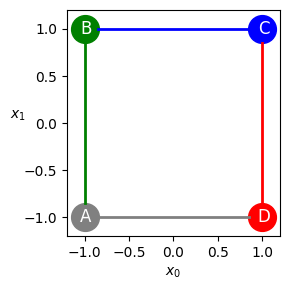

In [ ]:
fig = utils.counter_vs_clock(draw_arrows=False)

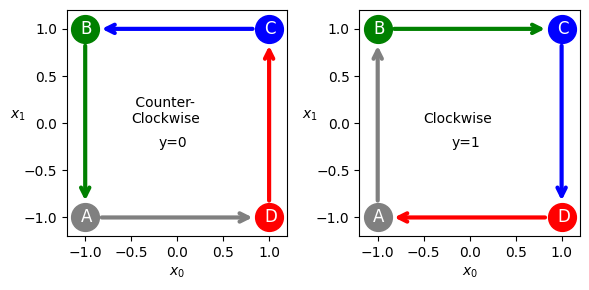

In [ ]:
fig = utils.counter_vs_clock()

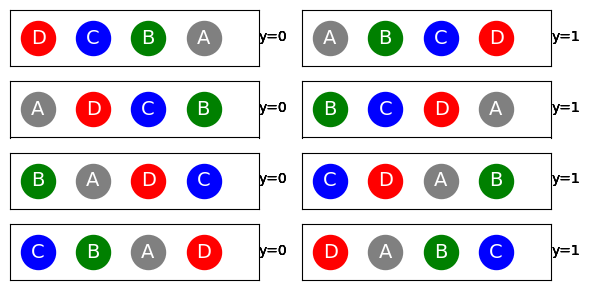

In [ ]:
fig = utils.plot_sequences()

In [ ]:
points, directions = utils.generate_sequences(n=128, seed=13)

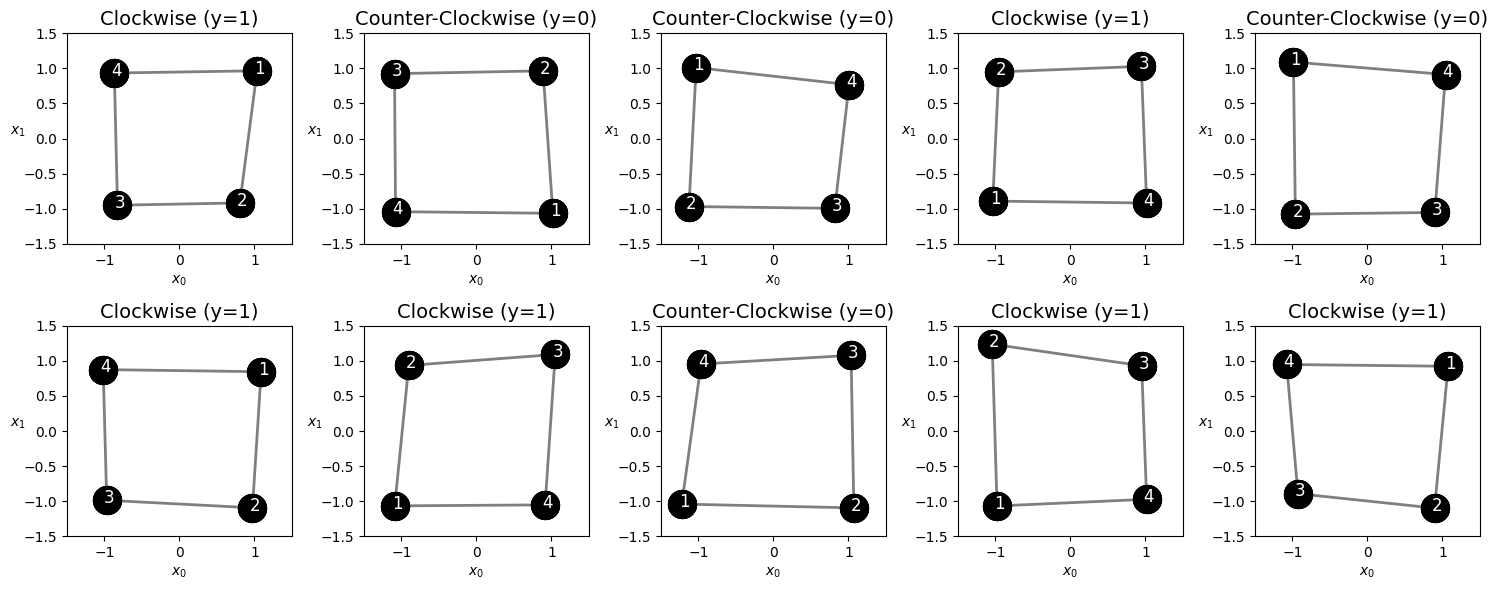

In [ ]:
fig = utils.plot_data(points, directions)

In [ ]:
points[0]

array([[ 1.03487506,  0.96613817],
       [ 0.80546093, -0.91690943],
       [-0.82507582, -0.94988627],
       [-0.86696831,  0.93424827]])

In [ ]:
points[0].shape

(4, 2)

## Recurrent Neural Networks (RNNs)

 Recurrent neural networks are all about
producing a hidden state that best represents a sequence.

In [ ]:
hidden_state = torch.zeros(2)
hidden_state

tensor([0., 0.])

![](images/rnn2.png)

### RNN Cell

![](images/rnn1.png)

![](images/rnn_cell_diagram.png)

transformed hidden state (th) ,
transformed data point (tx)

In [ ]:
n_features = 2
hidden_dim = 2

torch.manual_seed(19)
rnn_cell = nn.RNNCell(input_size=n_features, hidden_size=hidden_dim)
rnn_state = rnn_cell.state_dict()
rnn_state

OrderedDict([('weight_ih',
              tensor([[ 0.6627, -0.4245],
                      [ 0.5373,  0.2294]])),
             ('weight_hh',
              tensor([[-0.4015, -0.5385],
                      [-0.1956, -0.6835]])),
             ('bias_ih', tensor([0.4954, 0.6533])),
             ('bias_hh', tensor([-0.3565, -0.2904]))])

In [ ]:
linear_input = nn.Linear(n_features, hidden_dim)
linear_hidden = nn.Linear(hidden_dim, hidden_dim)

with torch.no_grad():
    linear_input.weight = nn.Parameter(rnn_state['weight_ih'])
    linear_input.bias = nn.Parameter(rnn_state['bias_ih'])
    linear_hidden.weight = nn.Parameter(rnn_state['weight_hh'])
    linear_hidden.bias = nn.Parameter(rnn_state['bias_hh'])

In [ ]:
initial_hidden = torch.zeros(1, hidden_dim)
initial_hidden

tensor([[0., 0.]])

In [ ]:
th = linear_hidden(initial_hidden)
th

tensor([[-0.3565, -0.2904]], grad_fn=<AddmmBackward0>)

In [ ]:
X = torch.as_tensor(points[0]).float()
X

tensor([[ 1.0349,  0.9661],
        [ 0.8055, -0.9169],
        [-0.8251, -0.9499],
        [-0.8670,  0.9342]])

In [ ]:
X[0:1]

tensor([[1.0349, 0.9661]])

In [ ]:
tx = linear_input(X[0:1])
tx

tensor([[0.7712, 1.4310]], grad_fn=<AddmmBackward0>)

In [ ]:
adding = th + tx
adding

tensor([[0.4146, 1.1405]], grad_fn=<AddBackward0>)

In [ ]:
torch.tanh(adding)

tensor([[0.3924, 0.8146]], grad_fn=<TanhBackward0>)

In [ ]:
rnn_cell(X[0:1])

tensor([[0.3924, 0.8146]], grad_fn=<TanhBackward0>)

In [ ]:
th

tensor([[-0.3565, -0.2904]], grad_fn=<AddmmBackward0>)

In [ ]:
linear_hidden(torch.tensor([[1,1]]).float())

tensor([[-1.2965, -1.1695]], grad_fn=<AddmmBackward0>)

In [ ]:
linear_hidden(torch.tensor([[-1,1]]).float())

tensor([[-0.4936, -0.7784]], grad_fn=<AddmmBackward0>)

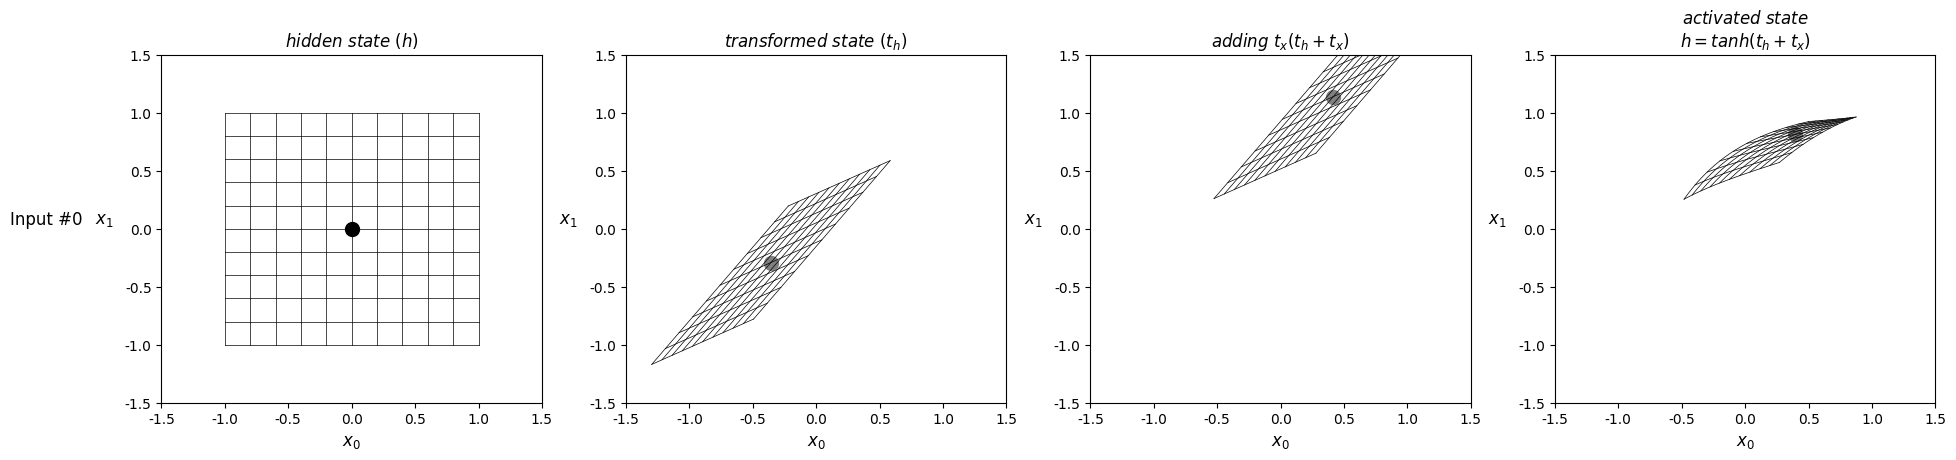

In [ ]:
fig = utils.figure8(linear_hidden, linear_input, X)

### The grid is a visualization of the possible values the hidden state can take in this 2D space. Each point on the grid represents a potential hidden state with coordinates
### The Black Dot Represents the Current Hidden State

In [ ]:
X

tensor([[ 1.0349,  0.9661],
        [ 0.8055, -0.9169],
        [-0.8251, -0.9499],
        [-0.8670,  0.9342]])

In [ ]:
X.shape

torch.Size([4, 2])

In [ ]:
# WRONG
rnn_cell(X)

tensor([[ 0.3924,  0.8146],
        [ 0.7864,  0.5266],
        [-0.0047, -0.2897],
        [-0.6817,  0.1109]], grad_fn=<TanhBackward0>)

In [ ]:
hidden = torch.zeros(1, hidden_dim)
for i in range(X.shape[0]):
    out = rnn_cell(X[i:i+1], hidden)
    print(out, 'Is the representation of the full sequence.' if  i == X.shape[0] - 1 else '')
    hidden = out

tensor([[0.3924, 0.8146]], grad_fn=<TanhBackward0>) 
tensor([[ 0.4347, -0.0481]], grad_fn=<TanhBackward0>) 
tensor([[-0.1521, -0.3367]], grad_fn=<TanhBackward0>) 
tensor([[-0.5297,  0.3551]], grad_fn=<TanhBackward0>) Is the representation of the full sequence.


![](images/rnn_cell_diagram_seq.png)

### RNN Layer

In [ ]:
n_features = 2
hidden_dim = 2

torch.manual_seed(19)
rnn = nn.RNN(input_size=n_features, hidden_size=hidden_dim)
rnn.state_dict()

OrderedDict([('weight_ih_l0',
              tensor([[ 0.6627, -0.4245],
                      [ 0.5373,  0.2294]])),
             ('weight_hh_l0',
              tensor([[-0.4015, -0.5385],
                      [-0.1956, -0.6835]])),
             ('bias_ih_l0', tensor([0.4954, 0.6533])),
             ('bias_hh_l0', tensor([-0.3565, -0.2904]))])

### Shapes

In [ ]:
points[0] #(L,F)

array([[ 1.03487506,  0.96613817],
       [ 0.80546093, -0.91690943],
       [-0.82507582, -0.94988627],
       [-0.86696831,  0.93424827]])

In [ ]:
len(points)

128

In [ ]:
batch = torch.as_tensor(points[:3]).float()
batch.shape
#(N, L, F)

<ipython-input-32-1d4cfaf3fa61>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  batch = torch.as_tensor(points[:3]).float()


torch.Size([3, 4, 2])

In [ ]:
points[:3]

[array([[ 1.03487506,  0.96613817],
        [ 0.80546093, -0.91690943],
        [-0.82507582, -0.94988627],
        [-0.86696831,  0.93424827]]),
 array([[ 1.0184946 , -1.06510565],
        [ 0.88794931,  0.96533932],
        [-1.09113448,  0.92538647],
        [-1.07709685, -1.04139537]]),
 array([[-1.02918114,  1.01267727],
        [-1.12473362, -0.9682829 ],
        [ 0.81815786, -0.99443078],
        [ 1.00808662,  0.76801524]])]

In [ ]:
batch.shape

torch.Size([3, 4, 2])

In [ ]:
#RNN-friendly -  RNNs use sequence-first by default
permuted_batch = batch.permute(1, 0, 2)
permuted_batch.shape

torch.Size([4, 3, 2])

In [ ]:
#RNN-friendly
torch.manual_seed(19)
rnn = nn.RNN(input_size=n_features, hidden_size=hidden_dim)
out, final_hidden = rnn(permuted_batch)
out.shape, final_hidden.shape

(torch.Size([4, 3, 2]), torch.Size([1, 3, 2]))

In [ ]:
final_hidden.permute(1,0,2)

tensor([[[-0.5297,  0.3551]],

        [[ 0.3142, -0.1232]],

        [[-0.2095,  0.4354]]], grad_fn=<PermuteBackward0>)

In [ ]:
out.permute(1,0,2)

tensor([[[ 0.3924,  0.8146],
         [ 0.4347, -0.0481],
         [-0.1521, -0.3367],
         [-0.5297,  0.3551]],

        [[ 0.8527,  0.5822],
         [-0.3259,  0.4595],
         [-0.7982, -0.2556],
         [ 0.3142, -0.1232]],

        [[-0.7500,  0.0422],
         [ 0.0827, -0.3325],
         [ 0.8480,  0.6559],
         [-0.2095,  0.4354]]], grad_fn=<PermuteBackward0>)

In [ ]:
out[-1]

tensor([[-0.5297,  0.3551],
        [ 0.3142, -0.1232],
        [-0.2095,  0.4354]], grad_fn=<SelectBackward0>)

In [ ]:
(out[-1] == final_hidden).all()

tensor(True)

In [ ]:
final_hidden.shape

torch.Size([1, 3, 2])

In [ ]:
batch_hidden = final_hidden.permute(1, 0, 2)
batch_hidden.shape

torch.Size([3, 1, 2])

In [ ]:
batch_hidden

tensor([[[-0.5297,  0.3551]],

        [[ 0.3142, -0.1232]],

        [[-0.2095,  0.4354]]], grad_fn=<PermuteBackward0>)

In [ ]:
batch.shape

torch.Size([3, 4, 2])

In [ ]:
torch.manual_seed(19)
rnn_batch_first = nn.RNN(input_size=n_features, hidden_size=hidden_dim, batch_first=True)
out, final_hidden = rnn_batch_first(batch)# batch -> (N, L, F)
out.shape, final_hidden.shape

(torch.Size([3, 4, 2]), torch.Size([1, 3, 2]))

### Stacked RNN

![](images/stacked_rnn.png)

In [ ]:
torch.manual_seed(19)
rnn_stacked = nn.RNN(input_size=2, hidden_size=2, num_layers=2, batch_first=True)
state = rnn_stacked.state_dict()
state

OrderedDict([('weight_ih_l0',
              tensor([[ 0.6627, -0.4245],
                      [ 0.5373,  0.2294]])),
             ('weight_hh_l0',
              tensor([[-0.4015, -0.5385],
                      [-0.1956, -0.6835]])),
             ('bias_ih_l0', tensor([0.4954, 0.6533])),
             ('bias_hh_l0', tensor([-0.3565, -0.2904])),
             ('weight_ih_l1',
              tensor([[-0.6701, -0.5811],
                      [-0.0170, -0.5856]])),
             ('weight_hh_l1',
              tensor([[ 0.1159, -0.6978],
                      [ 0.3241, -0.0983]])),
             ('bias_ih_l1', tensor([-0.3163, -0.2153])),
             ('bias_hh_l1', tensor([ 0.0722, -0.3242]))])

In [ ]:
list(state.items())

[('weight_ih_l0',
  tensor([[ 0.6627, -0.4245],
          [ 0.5373,  0.2294]])),
 ('weight_hh_l0',
  tensor([[-0.4015, -0.5385],
          [-0.1956, -0.6835]])),
 ('bias_ih_l0', tensor([0.4954, 0.6533])),
 ('bias_hh_l0', tensor([-0.3565, -0.2904])),
 ('weight_ih_l1',
  tensor([[-0.6701, -0.5811],
          [-0.0170, -0.5856]])),
 ('weight_hh_l1',
  tensor([[ 0.1159, -0.6978],
          [ 0.3241, -0.0983]])),
 ('bias_ih_l1', tensor([-0.3163, -0.2153])),
 ('bias_hh_l1', tensor([ 0.0722, -0.3242]))]

In [ ]:
list(state.items())[4:]

[('weight_ih_l1',
  tensor([[-0.6701, -0.5811],
          [-0.0170, -0.5856]])),
 ('weight_hh_l1',
  tensor([[ 0.1159, -0.6978],
          [ 0.3241, -0.0983]])),
 ('bias_ih_l1', tensor([-0.3163, -0.2153])),
 ('bias_hh_l1', tensor([ 0.0722, -0.3242]))]

In [ ]:
rnn_layer0 = nn.RNN(input_size=2, hidden_size=2, batch_first=True)
rnn_layer1 = nn.RNN(input_size=2, hidden_size=2, batch_first=True)

rnn_layer0.load_state_dict(dict(list(state.items())[:4]))
rnn_layer1.load_state_dict(dict([(k[:-1]+'0', v) for k, v in list(state.items())[4:]]))

<All keys matched successfully>

In [ ]:
x = torch.as_tensor(points[0:1]).float()

In [ ]:
out0, h0 = rnn_layer0(x)

In [ ]:
out1, h1 = rnn_layer1(out0)

In [ ]:
out1, torch.cat([h0, h1])

(tensor([[[-0.7533, -0.7711],
          [-0.0566, -0.5960],
          [ 0.4324, -0.2908],
          [ 0.1563, -0.5152]]], grad_fn=<TransposeBackward1>),
 tensor([[[-0.5297,  0.3551]],
 
         [[ 0.1563, -0.5152]]], grad_fn=<CatBackward0>))

In [ ]:
out, hidden = rnn_stacked(x)
out, hidden

(tensor([[[-0.7533, -0.7711],
          [-0.0566, -0.5960],
          [ 0.4324, -0.2908],
          [ 0.1563, -0.5152]]], grad_fn=<TransposeBackward1>),
 tensor([[[-0.5297,  0.3551]],
 
         [[ 0.1563, -0.5152]]], grad_fn=<StackBackward0>))

In [ ]:
(out[:, -1] == hidden.permute(1, 0, 2)[:, -1]).all()

tensor(True)

### Bidirectional RNN

![](images/bidirect_rnn.png)

Each "layer" starts with its own initial hidden state and produces its own final
hidden state

The **reverse layer** allows the network to look at **"future"** information in a given
sequence,

In [ ]:
torch.manual_seed(19)
rnn_bidirect = nn.RNN(input_size=2, hidden_size=2, bidirectional=True, batch_first=True)
state = rnn_bidirect.state_dict()
state

OrderedDict([('weight_ih_l0',
              tensor([[ 0.6627, -0.4245],
                      [ 0.5373,  0.2294]])),
             ('weight_hh_l0',
              tensor([[-0.4015, -0.5385],
                      [-0.1956, -0.6835]])),
             ('bias_ih_l0', tensor([0.4954, 0.6533])),
             ('bias_hh_l0', tensor([-0.3565, -0.2904])),
             ('weight_ih_l0_reverse',
              tensor([[-0.6701, -0.5811],
                      [-0.0170, -0.5856]])),
             ('weight_hh_l0_reverse',
              tensor([[ 0.1159, -0.6978],
                      [ 0.3241, -0.0983]])),
             ('bias_ih_l0_reverse', tensor([-0.3163, -0.2153])),
             ('bias_hh_l0_reverse', tensor([ 0.0722, -0.3242]))])

In [ ]:
out, hidden = rnn_bidirect(x)
out, hidden

(tensor([[[ 0.3924,  0.8146, -0.9355, -0.8353],
          [ 0.4347, -0.0481, -0.1766,  0.2596],
          [-0.1521, -0.3367,  0.8829,  0.0425],
          [-0.5297,  0.3551, -0.2032, -0.7901]]], grad_fn=<TransposeBackward1>),
 tensor([[[-0.5297,  0.3551]],
 
         [[-0.9355, -0.8353]]], grad_fn=<StackBackward0>))

In [ ]:
hidden,hidden.shape

(tensor([[[-0.5297,  0.3551]],
 
         [[-0.9355, -0.8353]]], grad_fn=<StackBackward0>),
 torch.Size([2, 1, 2]))

In [ ]:
out[:,-1]

tensor([[-0.5297,  0.3551, -0.2032, -0.7901]], grad_fn=<SelectBackward0>)

In [ ]:
out[:, -1] == hidden.permute(1, 0, 2).view(1, -1)

tensor([[ True,  True, False, False]])

## Square Model

### Data Generation

In [ ]:
test_points, test_directions = utils.generate_sequences(seed=19)

### Data Preparation

In [ ]:
train_data = TensorDataset(torch.as_tensor(points).float(),
                           torch.as_tensor(directions).view(-1, 1).float())
test_data = TensorDataset(torch.as_tensor(test_points).float(),
                          torch.as_tensor(test_directions).view(-1, 1).float())

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16)

### Model Configuration

In [ ]:
!pip install -q pytorch-lightning

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

class SquareModel(pl.LightningModule):
    def __init__(self, n_features, hidden_dim, n_outputs, learning_rate=0.01):
        super(SquareModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_features = n_features
        self.n_outputs = n_outputs
        self.learning_rate = learning_rate
        self.hidden = None
        # Simple RNN
        self.basic_rnn = nn.RNN(self.n_features, self.hidden_dim, batch_first=True)
        # Classifier to produce as many logits as outputs
        self.classifier = nn.Linear(self.hidden_dim, self.n_outputs)

        # Loss function
        self.loss = nn.BCEWithLogitsLoss()

    def forward(self, X):
        # X is batch first (N, L, F)
        # output for rnn is (N, L, H)
        # final hidden state is (1, N, H)
        batch_first_output, self.hidden  = self.basic_rnn(X)

        # only last item in sequence (N, 1, H)
        last_output = batch_first_output[:, -1]
        # classifier will output (N, 1, n_outputs)
        out = self.classifier(last_output)

        # final output is (N, n_outputs)
        return out.view(-1, self.n_outputs)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)

        # Calculate accuracy
        preds = torch.sigmoid(y_hat) > 0.5  # Convert logits to binary predictions
        acc = (preds == y).float().mean()   # Compute accuracy

        # Log loss and accuracy
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)

        # Calculate accuracy
        preds = torch.sigmoid(y_hat) > 0.5  # Convert logits to binary predictions
        acc = (preds == y).float().mean()   # Compute accuracy

        # Log loss and accuracy
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def test_step(self, batch, batch_idx):
        x = batch
        y_hat = self(x)
        self.log('test_predictions', y_hat)  # Log predictions (optional)
        return y_hat

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 43.2 MB/s eta 0:00:00


In [ ]:
model = SquareModel(n_features=2, hidden_dim=2, n_outputs=1)
logger = TensorBoardLogger("lightning_logs", name="square_model")
trainer = pl.Trainer(max_epochs=100, logger=logger)
trainer.fit(model, train_loader, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | basic_rnn  | RNN               | 12     | train
1 | classifier | Linear            | 3      | train
2 | loss       | BCEWithLogitsLoss | 0      | train
---------------------------------------------------------
15        Trainable params
0         Non-trainable params
15        Total params
0.000     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


pip install tensorboard



In [ ]:
!pip install  -q tensorboard

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs/

<IPython.core.display.Javascript object>

%load_ext tensorboard
%tensorboard --logdir=lightning_logs/

tensorboard --logdir=lightning_logs/

In [ ]:
for b in train_loader:
    o= model(b[0])
    break


In [ ]:
o.size()

torch.Size([16, 1])

In [ ]:
o[0]

tensor([1.1074], grad_fn=<SelectBackward0>)

### Model Training

## Visualizing the Model

### Transformed Inputs

In [ ]:
state = model.basic_rnn.state_dict()
state['weight_ih_l0'], state['bias_ih_l0']

(tensor([[-0.2613, -0.9526],
         [ 1.6524,  0.8213]]),
 tensor([1.0971, 0.4391]))

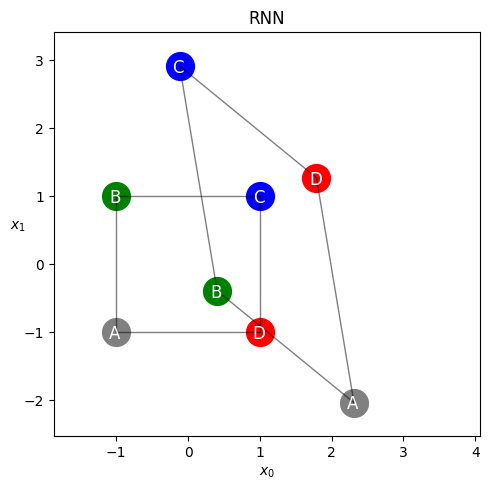

In [ ]:
fig = utils.figure13(model.basic_rnn)

### Hidden States

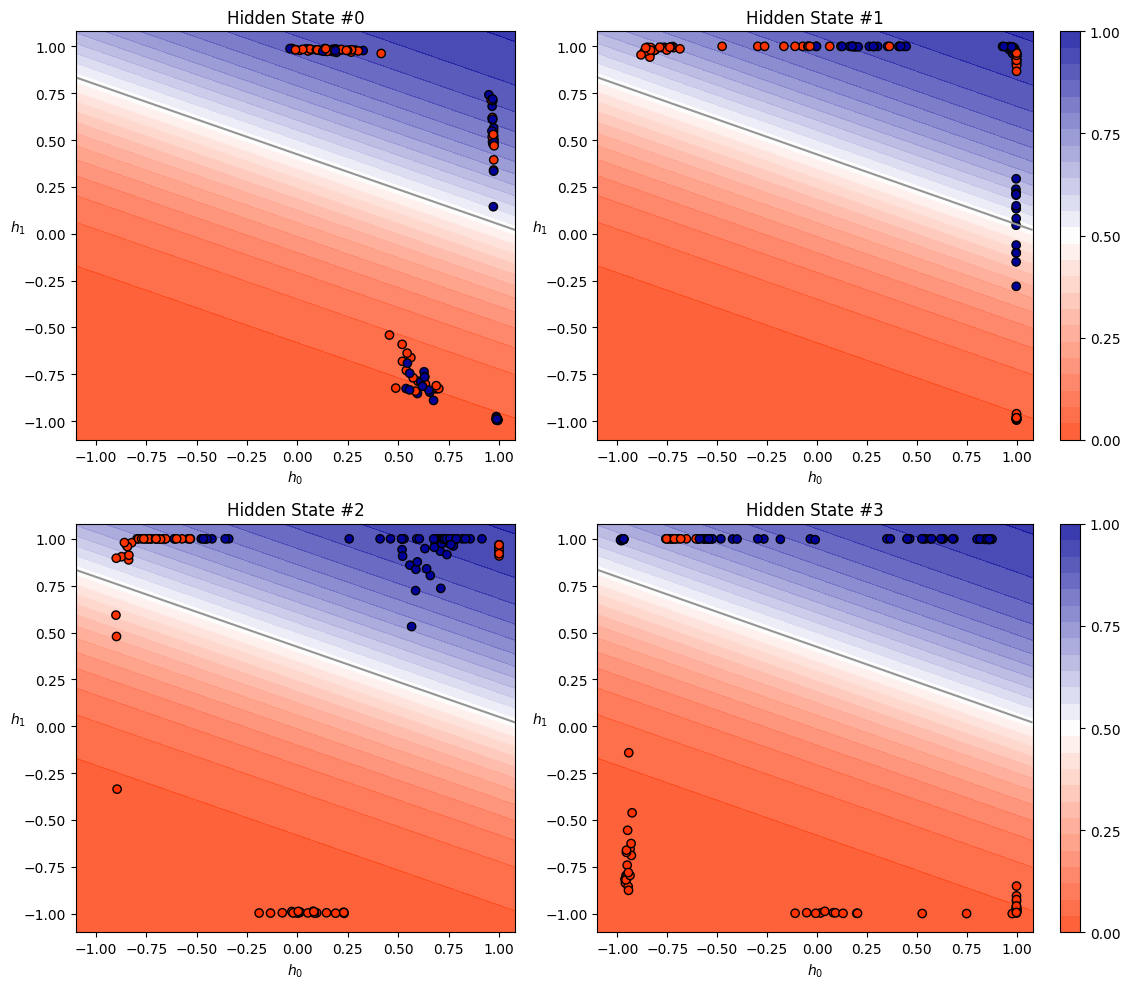

In [ ]:
fig = utils.hidden_states_contour(model, points, directions)

### The Journey of a Hidden State

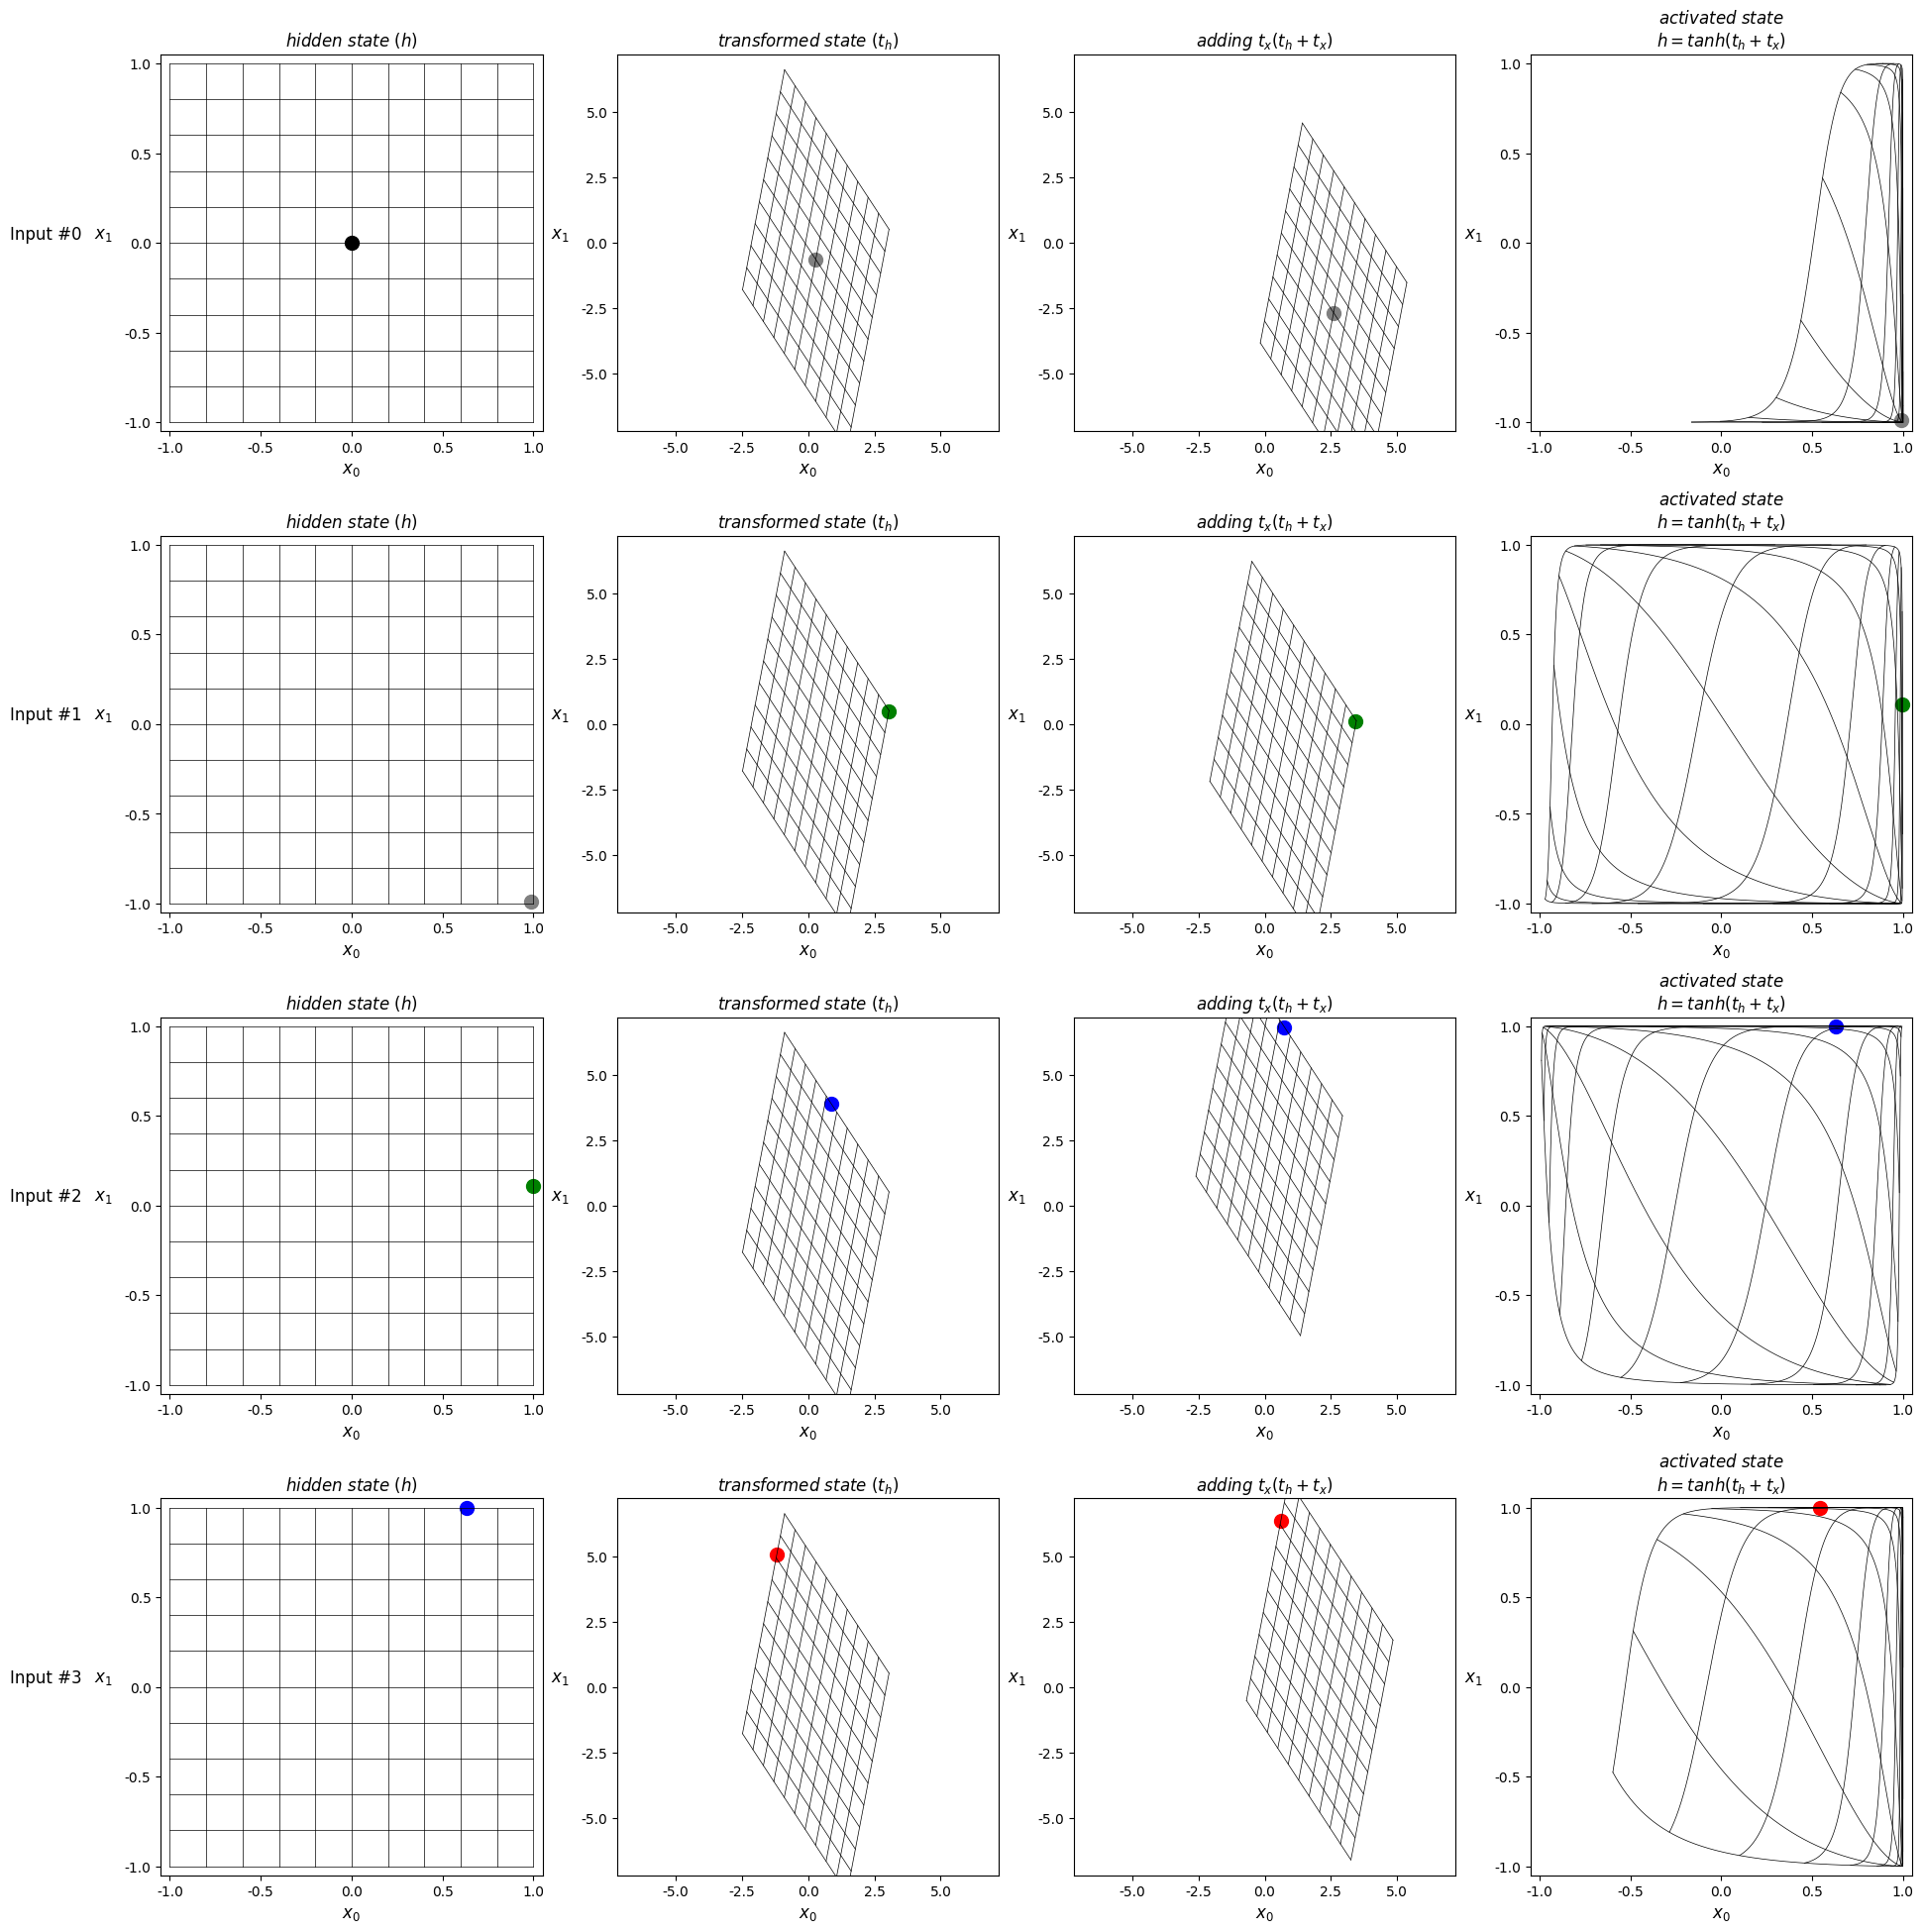

In [ ]:
fig = utils.figure16(model.basic_rnn)

In [ ]:
square = torch.tensor([[-1, -1], [-1, 1], [1, 1], [1, -1]]).float().view(1, 4, 2)
model(square)
model.hidden

tensor([[[0.5423, 1.0000]]], grad_fn=<StackBackward0>)

In [ ]:
fig = utils.figure17(model.basic_rnn)

## Gated Recurrent Units (GRUs)

$$
\Large
\begin{array}{rl}
h_{\text{new}} &= \text{tanh}(t_h + t_x) \\
h' &= h_{\text{new}} \cdot (1 - z) + h_{\text{old}} \cdot z
\end{array}
$$

$$
\Large
h_{\text{new}} = \text{tanh}(r*t_h + t_x)
$$

$$
\Large
h' = \text{tanh}(r*t_h + t_x) * (1-z) + h*z
$$

### GRU Cell

$$
\Large
\begin{array}{rl}
\text{RNN}: & h' = \text{tanh}(t_h + t_x) \\
\text{GRU}: & h' = \underbrace{\underbrace{\text{tanh}(\color{red}{r} \cdot t_{hn} + t_{xn})}_{n} \cdot \color{#0066CC}{(1 - z)} + \color{gray}{h} \cdot \color{#0066CC}{z}}_{\text{weighted average of } n \text{ and } h}
\end{array}
$$

$$
\Large
\begin{array}{rl}
& \color{red}{r\text{(reset gate)}} & \color{red}{=\sigma(t_{hr} + t_{xr})} \\
& \color{#0066CC}{z\text{(update gate)}} & \color{#0066CC}{=\sigma(t_{hz} + t_{xz})} \\
& \color{black}{n} & \color{black}{=\text{tanh}(\color{red}{r} \cdot t_{hn} + t_{xn})}
\end{array}
$$

$$
\Large
\begin{array}{rl}
\color{red}{r\ (\text{hidden})} & \color{red}{: t_{hr}} & \color{red}{=} & \color{red}{W_{hr}} & \color{red}{h} & \color{red}{+} & \color{red}{b_{hr}} \\
\color{red}{r\ (\text{input})} & \color{red}{: t_{xr}} & \color{red}{=} & \color{red}{W_{ir}} & \color{red}{x} & \color{red}{+} & \color{red}{b_{ir}} \\
\color{#0066CC}{z\ (\text{hidden})} & \color{#0066CC}{: t_{hz}} & \color{#0066CC}{=} & \color{#0066CC}{W_{hz}} & \color{#0066CC}{h} & \color{#0066CC}{+} & \color{#0066CC}{b_{hz}} \\
\color{#0066CC}{z\ (\text{input})} & \color{#0066CC}{: t_{xz}} & \color{#0066CC}{=} & \color{#0066CC}{W_{iz}} & \color{#0066CC}{x} & \color{#0066CC}{+} & \color{#0066CC}{b_{iz}} \\
n\ (\text{hidden}) & : t_{hn} & = & W_{hn} & h & + & b_{hn} \\
n\ (\text{input}) & : t_{xn} & = & W_{in} & x & + & b_{in}
\end{array}
$$

![](images/gru_cell.png)

## Square Model II: The Quickening

In [ ]:
class SquareModelGRU(pl.LightningModule):
    def __init__(self, n_features, hidden_dim, n_outputs, learning_rate=0.01):
        super(SquareModelGRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_features = n_features
        self.n_outputs = n_outputs
        self.learning_rate = learning_rate
        self.hidden = None
        # Simple GRU
        self.basic_rnn = nn.GRU(self.n_features, self.hidden_dim, batch_first=True)
        # Classifier to produce as many logits as outputs
        self.classifier = nn.Linear(self.hidden_dim, self.n_outputs)
        self.loss = nn.BCEWithLogitsLoss()

    def forward(self, X):
        # X is batch first (N, L, F)
        # output is (N, L, H)
        # final hidden state is (1, N, H)
        batch_first_output, self.hidden = self.basic_rnn(X)

        # only last item in sequence (N, 1, H)
        last_output = batch_first_output[:, -1]
        # classifier will output (N, 1, n_outputs)
        out = self.classifier(last_output)

        # final output is (N, n_outputs)
        return out.view(-1, self.n_outputs)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)

        # Calculate accuracy
        preds = torch.sigmoid(y_hat) > 0.5  # Convert logits to binary predictions
        acc = (preds == y).float().mean()   # Compute accuracy

        # Log loss and accuracy
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)

        # Calculate accuracy
        preds = torch.sigmoid(y_hat) > 0.5  # Convert logits to binary predictions
        acc = (preds == y).float().mean()   # Compute accuracy

        # Log loss and accuracy
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        self.log('test_predictions', y_hat)  # Log predictions (optional)
        return y_hat

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

### Model Configuration & Training

In [ ]:
model = SquareModelGRU(n_features=2, hidden_dim=2, n_outputs=1)
logger = TensorBoardLogger("lightning_logs", name="square_model_GRU")
trainer = pl.Trainer(max_epochs=100, logger=logger)
trainer.fit(model, train_loader, test_loader)

## Visualizing the Model

### Hidden States

In [ ]:
fig = utils.hidden_states_contour(model, points, directions)

### Journey of a GATED Hidden State

In [ ]:
fig = utils.figure22(model.basic_rnn)

# Gated Recurrent Unit (GRU) Observations

The **Gated Recurrent Unit (GRU)** is definitely an improvement over the regular RNN, but there are a couple of points worth noting:

---

### 1. **Reset Gate Inside Hyperbolic Tangent**
- Using the reset gate inside the **hyperbolic tangent** seems *"weird"* (not a scientific argument, but an observation).
- **Why it matters**: This design allows the GRU to **adaptively forget or retain information** based on the current input and context.

---

### 2. **Hidden State Bounded by Hyperbolic Tangent**
- **Best thing**: The hidden state is bounded by the **hyperbolic tangent**, ensuring the next cell receives values in a **stable range** (between -1 and 1).
- **Worst thing**: The bounded nature of the hyperbolic tangent **constrains the values** the hidden state can take, which also limits the **gradients**.

---

### 3. **Two Hidden States in the Same Cell**
- Since we can't have the **best of both worlds** (bounded and unbounded hidden states), why not use **two hidden states** in the same cell?
  - One hidden state could be **bounded** (e.g., using `tanh`) for stability.
  - The other could be **unbounded** (e.g., using a linear transformation) for greater expressiveness.
- **Potential benefit**: Combines **stability** with **flexibility**.

## Long Short-Term Memory (LSTM)

$$
\Large
g = \text{tanh}(t_{hg}+t_{xg})
$$

$$
\Large
c' = g * i + c * f
$$

$$
\Large
h' = \text{tanh}(c') * o
$$

### LSTM Cell

$$
\Large
\begin{array}{rl}
\text{RNN}: & h' = \text{tanh}(t_h + t_x) \\
\text{GRU}: & h' = \text{tanh}(r \cdot t_{hn} + t_{xn}) \cdot (1 - z) + h \cdot z \\
\text{LSTM}: & c' = \underbrace{\text{tanh}(t_{hg} + t_{xg})}_{g} \cdot \color{#82b366}{i} + \color{gray}{c} \cdot \color{red}{f} \\
& h' = \text{tanh}(c') \cdot \color{#0066cc}{o}
\end{array}
$$

$$
\Large
\begin{array}{rl}
& \color{#82b366}{i\text{(nput gate)}} & = \color{#82b366}{\sigma(t_{hi} + t_{xi})} \\
& \color{red}{f\text{(orget gate)}} & = \color{red}{\sigma(t_{hf} + t_{xf})} \\
& \color{#0066cc}{o\text{(utput gate)}} & = \color{#0066cc}{\sigma(t_{ho} + t_{xo})} \\
& g & = \text{tanh}(t_{hg} + t_{xg})
\end{array}
$$

$$
\Large
\begin{array}{rl}
 \color{#82b366}{i\ \text{(hidden)}} & \color{#82b366}{: t_{hi}} & \color{#82b366}{=} & \color{#82b366}{W_{hi}} & \color{#82b366}{h} & \color{#82b366}{+} & \color{#82b366}{b_{hi}} \\
\color{#82b366}{i\ \text{(input)}} & \color{#82b366}{: t_{xi}} & \color{#82b366}{=} & \color{#82b366}{W_{ii}} & \color{#82b366}{x} & \color{#82b366}{+} & \color{#82b366}{b_{ii}} \\
\color{red}{f\ \text{(hidden)}} & \color{red}{: t_{hf}} & \color{red}{=} & \color{red}{W_{hf}} & \color{red}{h} & \color{red}{+} & \color{red}{b_{hf}} \\
\color{red}{f\ \text{(input)}} & \color{red}{: t_{xf}} & \color{red}{=} & \color{red}{W_{if}} & \color{red}{x} & \color{red}{+} & \color{red}{b_{if}} \\
g\ \text{(hidden)} & : t_{hg} & = & W_{hg} & h & + & b_{hg} \\
g\ \text{(input)} & : t_{xg} & = & W_{ig} & x & + & b_{ig} \\
\color{#0066cc}{o\ \text{(hidden)}} & \color{#0066cc}{: t_{ho}} & \color{#0066cc}{=} & \color{#0066cc}{W_{ho}} & \color{#0066cc}{h} & \color{#0066cc}{+} & \color{#0066cc}{b_{ho}} \\
\color{#0066cc}{o\ \text{(input)}} & \color{#0066cc}{: t_{xo}} & \color{#0066cc}{=} & \color{#0066cc}{W_{io}} & \color{#0066cc}{x} & \color{#0066cc}{+} & \color{#0066cc}{b_{io}}
\end{array}
$$

![](images/lstm_cell.png)

## LSTM Layer

## Square Model III: The Sorcerer

### Model Configuration

In [ ]:
class SquareModelLSTM(pl.LightningModule):
    def __init__(self, n_features, hidden_dim, n_outputs, learning_rate=0.01):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_features = n_features
        self.n_outputs = n_outputs
        self.learning_rate = learning_rate
        self.hidden = None
        self.cell = None
        # Simple LSTM
        self.basic_rnn = nn.LSTM(self.n_features, self.hidden_dim, batch_first=True)
        # Classifier to produce as many logits as outputs
        self.classifier = nn.Linear(self.hidden_dim, self.n_outputs)
        self.loss = nn.BCEWithLogitsLoss()

    def forward(self, X):
        # X is batch first (N, L, F)
        # output is (N, L, H)
        # final hidden state is (1, N, H)
        # final cell state is (1, N, H)
        batch_first_output, (self.hidden, self.cell) = self.basic_rnn(X)

        # only last item in sequence (N, 1, H)
        last_output = batch_first_output[:, -1]
        # classifier will output (N, 1, n_outputs)
        out = self.classifier(last_output)

        # final output is (N, n_outputs)
        return out.view(-1, self.n_outputs)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)

        # Calculate accuracy
        preds = torch.sigmoid(y_hat) > 0.5  # Convert logits to binary predictions
        acc = (preds == y).float().mean()   # Compute accuracy

        # Log loss and accuracy
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)

        # Calculate accuracy
        preds = torch.sigmoid(y_hat) > 0.5  # Convert logits to binary predictions
        acc = (preds == y).float().mean()   # Compute accuracy

        # Log loss and accuracy
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        self.log('test_predictions', y_hat)  # Log predictions (optional)
        return y_hat

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

### Model Configuration & Training

In [ ]:
model = SquareModelLSTM(n_features=2, hidden_dim=2, n_outputs=1)
logger = TensorBoardLogger("lightning_logs", name="square_model_LSTM")
trainer = pl.Trainer(max_epochs=100, logger=logger)
trainer.fit(model, train_loader, test_loader)

## Visualizing the Hidden States

In [ ]:
fig = utils.hidden_states_contour(model, points, directions)

In [ ]:
#previuse code does not concat cell state and hidden state for classifier
class SquareModelLSTMCellStateCat(pl.LightningModule):
    def __init__(self, n_features, hidden_dim, n_outputs, learning_rate=0.01):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_features = n_features
        self.n_outputs = n_outputs
        self.learning_rate = learning_rate
        self.hidden = None
        self.cell = None
        # Simple LSTM
        self.basic_rnn = nn.LSTM(self.n_features, self.hidden_dim, batch_first=True)
        # Classifier to produce as many logits as outputs
        self.classifier = nn.Linear(self.hidden_dim * 2, self.n_outputs)  # Adjusted input size
        self.loss = nn.BCEWithLogitsLoss()

    def forward(self, X):
        # X is batch first (N, L, F)
        # output is (N, L, H)
        # final hidden state is (1, N, H)
        # final cell state is (1, N, H)
        batch_first_output, (self.hidden, self.cell) = self.basic_rnn(X)

        # only last item in sequence (N, 1, H)
        last_hidden = self.hidden[-1]  # (N, H)
        last_cell = self.cell[-1]      # (N, H)

        # concatenate hidden state and cell state (N, 2H)
        combined = torch.cat((last_hidden, last_cell), dim=1)

        # classifier will output (N, 1, n_outputs)
        out = self.classifier(combined)

        # final output is (N, n_outputs)
        return out.view(-1, self.n_outputs)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)

        # Calculate accuracy
        preds = torch.sigmoid(y_hat) > 0.5  # Convert logits to binary predictions
        acc = (preds == y).float().mean()   # Compute accuracy

        # Log loss and accuracy
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)

        # Calculate accuracy
        preds = torch.sigmoid(y_hat) > 0.5  # Convert logits to binary predictions
        acc = (preds == y).float().mean()   # Compute accuracy

        # Log loss and accuracy
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        self.log('test_predictions', y_hat)  # Log predictions (optional)
        return y_hat

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

In [ ]:
model = SquareModelLSTMCellStateCat(n_features=2, hidden_dim=2, n_outputs=1)
logger = TensorBoardLogger("lightning_logs", name="square_model_LSTM_cell_state_cat")
trainer = pl.Trainer(max_epochs=100, logger=logger)
trainer.fit(model, train_loader, test_loader)